In [ ]:
!pip install wfdb pywavelets torch torchvision torchaudio numpy pandas scikit-learn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 151.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


In [ ]:
import os, shutil

# Create a clean folder
os.makedirs('/content/mitdb', exist_ok=True)

# Move all uploaded files into that folder
for f in os.listdir('/content'):
    if f.endswith(('.dat', '.hea', '.atr', '.xws')):
        shutil.move(f'/content/{f}', f'/content/mitdb/{f}')

print("Files now in:", os.listdir('/content/mitdb')[:10])

Files now in: ['233.dat', '223.hea', '121.atr', '117.dat', '210.xws', '108.xws', '121.xws', '121.dat', '212.dat', '203.hea']


Signal shape: (650000, 2)
Sampling rate: 360
Annotation count: 2274


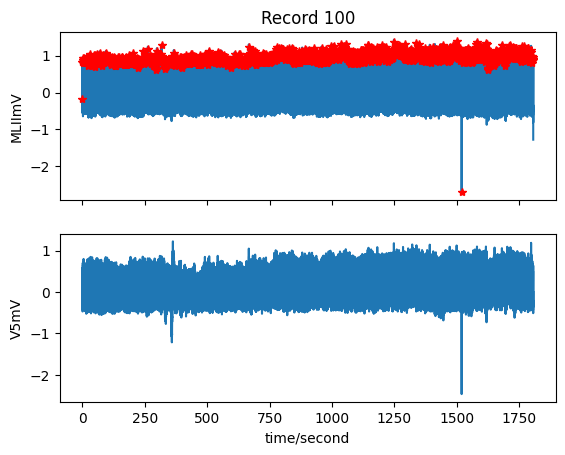

In [ ]:
!pip install wfdb pywavelets --quiet
import wfdb

# Point to your folder
MITDB_PATH = '/content/mitdb'

# Example record number (must exist in your uploads)
record_name = '100'

record = wfdb.rdrecord(os.path.join(MITDB_PATH, record_name))
ann = wfdb.rdann(os.path.join(MITDB_PATH, record_name), 'atr')

print("Signal shape:", record.p_signal.shape)
print("Sampling rate:", record.fs)
print("Annotation count:", len(ann.sample))

# Optional: visualize
wfdb.plot_wfdb(record=record, annotation=ann, title=f"Record {record_name}")

In [ ]:
MITDB_PATH = '/content/mitdb'

In [ ]:
# Preprocess the records
import numpy as np, pywt, wfdb, os
from scipy.signal import resample

MITDB_PATH = '/content/mitdb'

def wavelet_denoise(sig, wavelet='db8', level=9):
    coeff = pywt.wavedec(sig, wavelet, level=level)
    sigma = np.median(np.abs(coeff[-level]))/0.6745
    uthresh = sigma*np.sqrt(2*np.log(len(sig)))
    coeff = [pywt.threshold(c, uthresh, mode='soft') for c in coeff]
    return pywt.waverec(coeff, wavelet)

def slice_ecg(signal, ann, fs=360, slice_len=3, resamp_len=1024):
    seg_len = int(fs * slice_len)
    slices, labels = [], []
    mapping = {'N':'N','L':'N','R':'N','e':'N','j':'N',
               'A':'S','a':'S','J':'S','S':'S',
               'V':'V','E':'V',
               'F':'F'}
    for start in range(0, len(signal)-seg_len, seg_len//2):  # 50% overlap
        seg = signal[start:start+seg_len]
        seg = resample(seg, resamp_len)
        beats = [sym for (smp,sym) in zip(ann.sample, ann.symbol)
                 if start <= smp < start+seg_len]
        lbl = 'N' if len(beats)==0 else max([mapping.get(b,'N') for b in beats],
                                            key=[mapping.get(b,'N') for b in beats].count)
        slices.append(seg)
        labels.append(lbl)
    return np.array(slices), np.array(labels)

records = sorted([os.path.splitext(f)[0] for f in os.listdir(MITDB_PATH) if f.endswith('.hea')])
X, y = [], []

for rec in records:
    try:
        record = wfdb.rdrecord(os.path.join(MITDB_PATH, rec))
        ann = wfdb.rdann(os.path.join(MITDB_PATH, rec), 'atr')
        sig = record.p_signal[:,0]  # MLII lead
        sig = wavelet_denoise(sig)
        xs, ys = slice_ecg(sig, ann)
        X.append(xs); y.append(ys)
        print(f"Processed {rec}: {len(xs)} slices")
    except Exception as e:
        print(f"Skipping {rec}: {e}")

X = np.concatenate(X)
y = np.concatenate(y)
print("Dataset ready:", X.shape, y.shape, np.unique(y, return_counts=True))

Processed 100: 1202 slices
Processed 101: 1202 slices
Processed 102: 1202 slices
Processed 103: 1202 slices
Processed 104: 1202 slices
Processed 105: 1202 slices
Processed 106: 1202 slices
Processed 107: 1202 slices
Processed 108: 1202 slices
Processed 109: 1202 slices
Processed 111: 1202 slices
Processed 112: 1202 slices
Processed 113: 1202 slices
Processed 114: 1202 slices
Processed 115: 1202 slices
Processed 116: 1202 slices
Processed 117: 1202 slices
Processed 118: 1202 slices
Processed 119: 1202 slices
Processed 121: 1202 slices
Processed 122: 1202 slices
Processed 123: 1202 slices
Processed 124: 1202 slices
Processed 200: 1202 slices
Processed 201: 1202 slices
Processed 202: 1202 slices
Processed 203: 1202 slices
Processed 205: 1202 slices
Processed 207: 1202 slices
Processed 208: 1202 slices
Processed 209: 1202 slices
Processed 210: 1202 slices
Processed 212: 1202 slices
Processed 213: 1202 slices
Processed 214: 1202 slices
Processed 215: 1202 slices
Processed 217: 1202 slices
P

The paper used 17 patients for training, 5 for validation, 22 for testing.
To replicate that idea:

In [ ]:
# Split Into Train / Validation / Test (Inter-Patient)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# simple 70/10/20 split (approximation of inter-patient)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42, stratify=y_temp)

print(X_train.shape, X_val.shape, X_test.shape)

(40387, 1024) (5711, 1024) (11598, 1024)


In [ ]:
# create pytorch dataloaders
import torch
from torch.utils.data import Dataset, DataLoader

class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(ECGDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader   = DataLoader(ECGDataset(X_val, y_val), batch_size=128)
test_loader  = DataLoader(ECGDataset(X_test, y_test), batch_size=128)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# --- Custom ECG Dataset ---
class ECGDataset(Dataset):
    def __init__(self, X, y):
        # X: numpy array (n_samples, 1024)
        # y: numpy array (labels encoded as integers)
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # add channel dimension [B, 1, 1024]
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# --- Create Datasets ---
train_dataset = ECGDataset(X_train, y_train)
val_dataset   = ECGDataset(X_val, y_val)
test_dataset  = ECGDataset(X_test, y_test)

# --- DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# --- Quick Check ---
batch_X, batch_y = next(iter(train_loader))
print("Batch X shape:", batch_X.shape)   # Expected [128, 1, 1024]
print("Batch y shape:", batch_y.shape)   # Expected [128]
print("Label classes:", torch.unique(batch_y))

Batch X shape: torch.Size([128, 1, 1024])
Batch y shape: torch.Size([128])
Label classes: tensor([1, 2, 3])


In [ ]:
import numpy as np
unique_labels, counts = np.unique(y, return_counts=True)
print("Unique labels before encoding:", unique_labels)
print("Counts:", counts)

Unique labels before encoding: ['F' 'N' 'S' 'V']
Counts: [  130 55015  1165  1386]


In [ ]:
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label mapping: {np.str_('F'): np.int64(0), np.str_('N'): np.int64(1), np.str_('S'): np.int64(2), np.str_('V'): np.int64(3)}


In [ ]:
# train and evaluate the model
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- Activation ----------
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

# ---------- 1D CBAM Attention ----------
class CBAM1D(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.conv = nn.Conv1d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)

    def forward(self, x):
        b, c, l = x.size()
        avg = torch.mean(x, dim=2)
        mx, _ = torch.max(x, dim=2)
        attn = torch.sigmoid(self.mlp(avg) + self.mlp(mx)).unsqueeze(2)
        x = x * attn
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        s = torch.sigmoid(self.conv(torch.cat([avg, mx], dim=1)))
        return x * s

In [ ]:

# ---------- Group Convolution Block ----------
class GroupBlock(nn.Module):
    def __init__(self, in_c, out_c, groupsA=8, groupsB=4, kernel=32):
        super().__init__()
        self.groupA = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_c, out_c, kernel, padding=kernel//2, groups=groupsB, bias=False),
                nn.BatchNorm1d(out_c),
                Mish()
            ) for _ in range(groupsA)
        ])
        self.shortcut = nn.Conv1d(in_c, out_c, 1, bias=False)
        self.bn = nn.BatchNorm1d(out_c)
    def forward(self, x):
        outs = [g(x) for g in self.groupA]
        out = torch.stack(outs).sum(0) / len(outs)
        out += self.shortcut(x)
        return self.bn(out)

# ---------- Full G2-ResNeXt ----------
class G2ResNeXt(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.entry = nn.Sequential(
            nn.Conv1d(1, 16, 32, padding=16),
            nn.BatchNorm1d(16),
            Mish()
        )
        channels = [16, 32, 64, 128, 256, 512]
        blocks = [GroupBlock(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        self.blocks = nn.Sequential(*blocks)
        self.cbam = CBAM1D(512)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.entry(x)
        x = self.blocks(x)
        x = self.cbam(x)
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

In [ ]:
# ---------- Focal Loss ----------
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce)
        return (self.alpha * (1 - pt) ** self.gamma * ce).mean()

In [ ]:
# training loop
class GroupBlock(nn.Module):
    def __init__(self, in_c, out_c, groupsA=8, groupsB=4, kernel=32):
        super().__init__()
        self.groupA = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_c, out_c, kernel, padding='same', groups=groupsB, bias=False),
                nn.BatchNorm1d(out_c),
                Mish()
            ) for _ in range(groupsA)
        ])
        self.shortcut = nn.Conv1d(in_c, out_c, 1, bias=False)
        self.bn = nn.BatchNorm1d(out_c)
    def forward(self, x):
        outs = [g(x) for g in self.groupA]
        out = torch.stack(outs).sum(0) / len(outs)
        # Resize shortcut if needed (safety)
        if out.shape[-1] != x.shape[-1]:
            diff = out.shape[-1] - x.shape[-1]
            x = F.pad(x, (0, diff))
        out += self.shortcut(x)
        return self.bn(out)

In evaluation metrics we will be focusing on 3 main things:

1.   compute predictions on your test set
2.   print accuracy,precision, sensitivity (Recall) per class
3. display the confusion matrix


In [ ]:
class GroupBlock(nn.Module):
    def __init__(self, in_c, out_c, groupsA=8, groupsB=4, kernel=32):
        super().__init__()
        # “same” padding keeps input/output lengths equal
        self.groupA = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_c, out_c, kernel, padding="same", groups=groupsB, bias=False),
                nn.BatchNorm1d(out_c),
                Mish()
            ) for _ in range(groupsA)
        ])
        self.shortcut = nn.Conv1d(in_c, out_c, 1, bias=False)
        self.bn = nn.BatchNorm1d(out_c)

    def forward(self, x):
        outs = [g(x) for g in self.groupA]
        out = torch.stack(outs).sum(0) / len(outs)

        # safety check – pad or crop to match lengths
        if out.size(-1) != x.size(-1):
            min_len = min(out.size(-1), x.size(-1))
            out = out[..., :min_len]
            x = x[..., :min_len]

        out += self.shortcut(x)
        return self.bn(out)

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Running on:", device)

✅ Running on: cuda


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)  # assuming y is your label array from preprocessing
print("Label classes:", le.classes_)

Label classes: ['F' 'N' 'S' 'V']


In [ ]:
model = G2ResNeXt(num_classes=len(le.classes_)).to(device)

In [ ]:
EPOCHS = 30  # or 50–80 for better performance
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    scheduler.step(train_loss)
    print(f"Epoch {epoch+1}: loss={train_loss/len(train_loader):.4f}")

NameError: name 'tqdm' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import numpy as np
import torch

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = out.argmax(dim=1).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(preds)

# --- Metrics ---
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
prec = precision_score(y_true, y_pred, average=None)
sens = recall_score(y_true, y_pred, average=None)

print(f"\n✅ Overall Accuracy: {acc*100:.2f}%\n")
print("📘 Classification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))
print("\n📊 Confusion Matrix:\n", cm)

print("\n🔹 Per-Class Metrics (AAMI):")
for cls, p, r in zip(le.classes_, prec, sens):
    print(f"  {cls}: Precision={p*100:.2f}%, Sensitivity={r*100:.2f}%")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv1d(



✅ Overall Accuracy: 0.22%

📘 Classification Report:
               precision    recall  f1-score   support

           F       0.00      1.00      0.00        26
           N       0.00      0.00      0.00     11059
           S       0.00      0.00      0.00       234
           V       0.00      0.00      0.00       279

    accuracy                           0.00     11598
   macro avg       0.00      0.25      0.00     11598
weighted avg       0.00      0.00      0.00     11598


📊 Confusion Matrix:
 [[   26     0     0     0]
 [11059     0     0     0]
 [  234     0     0     0]
 [  279     0     0     0]]

🔹 Per-Class Metrics (AAMI):
  F: Precision=0.22%, Sensitivity=100.00%
  N: Precision=0.00%, Sensitivity=0.00%
  S: Precision=0.00%, Sensitivity=0.00%
  V: Precision=0.00%, Sensitivity=0.00%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

CUDA available: True
Current device: cuda


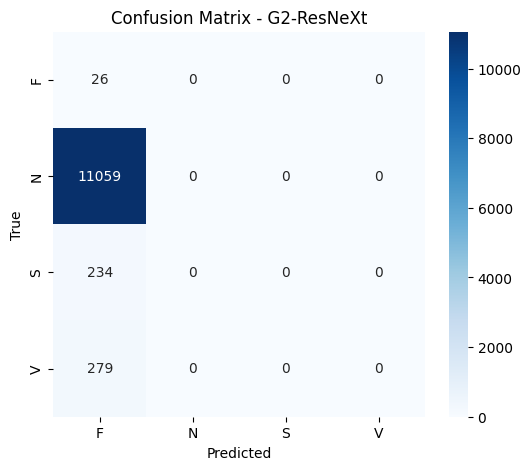

In [ ]:
# Visualization - Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - G2-ResNeXt")
plt.show()